# Приоритизация гипотез в интернет-магазине. A/B тест.

# Описание проекта  
Контекст  
Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.  

В проекте будет:
1. Проведена приоритизация гипотез по методам ICE и RICE


2. Проведен А/В тест:
- построены графики кумулятивного среднего чека и кумулятивного среднего количества заказов на посетителя
- посчитана статистическая значимость различий показателей между группами А и В
- сделаны выводы об успешности теста
 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re

### Загрузим данные и подготовим их к анализу

In [2]:
try:
    hypothesis, orders, visitors = (
        pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv'),
        pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv', parse_dates=['date']),
        pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv', parse_dates=['date'])
    
        )
except FileNotFoundError:
    print('Некорректный путь к файлу')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 150)
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Hypothesis — краткое описание гипотезы;  
Reach — охват пользователей по 10-балльной шкале;  
Impact — влияние на пользователей по 10-балльной шкале;  
Confidence — уверенность в гипотезе по 10-балльной шкале;  
Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [4]:
hypothesis.columns = hypothesis.columns.str.lower()

In [5]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [6]:
def camel_to_snake(s):
    return ''.join(['_'+c.lower() if c.isupper() else c for c in s]).lstrip('_')

In [7]:
orders.columns = orders.columns.map(lambda x: camel_to_snake(x))

transactionId — идентификатор заказа;  
visitorId — идентификатор пользователя, совершившего заказ;  
date — дата, когда был совершён заказ;  
revenue — выручка заказа;  
group — группа A/B-теста, в которую попал заказ.

In [8]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


date — дата;  
group — группа A/B-теста;  
visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [9]:
# функция для ознакомления с данными
def look_at (data):
    data.info()
    print('*'*50)
    print('Пропуски:')
    display(data.isna().sum())
    print('*'*50)
    if data.duplicated().sum() > 0:
        print('Дубликатов: ', data.duplicated().sum())
    else:
        print('Явные дубликаты не обнаружены')

In [10]:
look_at(hypothesis)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
**************************************************
Пропуски:


hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

**************************************************
Явные дубликаты не обнаружены


In [11]:
look_at(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
**************************************************
Пропуски:


transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64

**************************************************
Явные дубликаты не обнаружены


In [12]:
print('\nНачальная дата {}, конечная дата {}\n'.format(orders['date'].min(), orders['date'].max()))


Начальная дата 2019-08-01 00:00:00, конечная дата 2019-08-31 00:00:00



In [13]:
look_at(visitors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
**************************************************
Пропуски:


date        0
group       0
visitors    0
dtype: int64

**************************************************
Явные дубликаты не обнаружены


In [14]:
print('\nНачальная дата {}, конечная дата {}\n'.format(visitors['date'].min(), visitors['date'].max()))


Начальная дата 2019-08-01 00:00:00, конечная дата 2019-08-31 00:00:00



#### Выводы по разделу 1

Проведена предобработка данных:
- наименования полей приведены к единому нижнему регистру  
- значения с датами преобразованы в формат datetime  

Пропуски и дубликаты не обнаружены.

Выгрузки за период с 2019-08-01 до 2019-08-31 

### Часть 1. Приоритизация гипотез
В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.  
Задача  
Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

#### Приоритизация гипотез методом ICE

In [15]:
hypothesis['ice'] = round((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 2)
hypothesis[['hypothesis','ice']].sort_values('ice', ascending=False)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Наиболее перспективные гипотезы по методу ICE 8 (Запустить акцию, дающую скидку на товар в день рождения), 0 (Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей), 7 (Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок).

#### Приоритизация гипотез методом RICE

In [16]:
hypothesis['rice'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis','rice']].sort_values('rice', ascending=False)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Наиболее перспективные гипотезы по методу RICE 7 (Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок), 2 (Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа), 0 (Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей), 6 (Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию).

#### Выводы по разделу 2

RICE учитывает оценку количества пользователей, которых затронут изменения и чем их больше, тем приоритет гипотезы выше. По нему в топе оказались гипотезы 7, 2, 0, 6. Для ICE этот критерий не учитывается. По нему в топе оказались гипотезы 8, 0, 7.  

Если смотреть совпадения по обоим методам, наиболее привлекательными оказываются гипотезы 7 (Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок) и 0 (Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей).

### Часть 2. Анализ A/B-теста
Мы провели A/B-тест и получили результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.  
Задача  
Проанализируйте A/B-тест:
Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.  
Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.  
Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.  
Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.  
Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.  
Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.  
Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.  
Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.  
Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.  
Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.  
Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.  
Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.  
Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.  
Примите решение по результатам теста и объясните его. Варианты решений:  
1. Остановить тест, зафиксировать победу одной из групп.  
2. Остановить тест, зафиксировать отсутствие различий между группами.  
3. Продолжить тест.  

In [17]:
# отбираем группы из данных с заказами 
group_a=orders.query('group == "A"') 
group_b=orders.query('group == "B"') 
  
# получаем количество пользователей, попавших в обе группы 
group_intersections=list(np.intersect1d(group_a['visitor_id'], group_b['visitor_id']))
len(group_intersections)


58

In [18]:
round(len(group_intersections)/len(group_a),2)

0.1

In [19]:
round(len(group_intersections)/len(group_b),2)

0.09

58 пользователей попали в обе группы, что составляет 9-10% от каждой выборки.  
Для данного исследования не будем исключать их, поскольку это значительная часть данных.

#### Проанализируем A/B-тест: построим график кумулятивной выручки по группам. 

In [20]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date', 'group']].drop_duplicates().reset_index(drop=True)

# получаем агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = (dates_groups
                    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                                           orders['group'] == x['group'])]
                           .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique',
                                 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1)
                    .sort_values(by=['date','group'])
                    .reset_index(drop=True))
                    
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitors_aggregated = (dates_groups
                      .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
                                                               visitors['group'] == x['group'])]
                             .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
                      .sort_values(by=['date','group'])
                      .reset_index(drop=True))

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(visitors_aggregated, on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulative_data['aov'] = cumulative_data["revenue"] / cumulative_data["orders"]
cumulative_data['conversion'] = cumulative_data["orders"] / cumulative_data["visitors"]

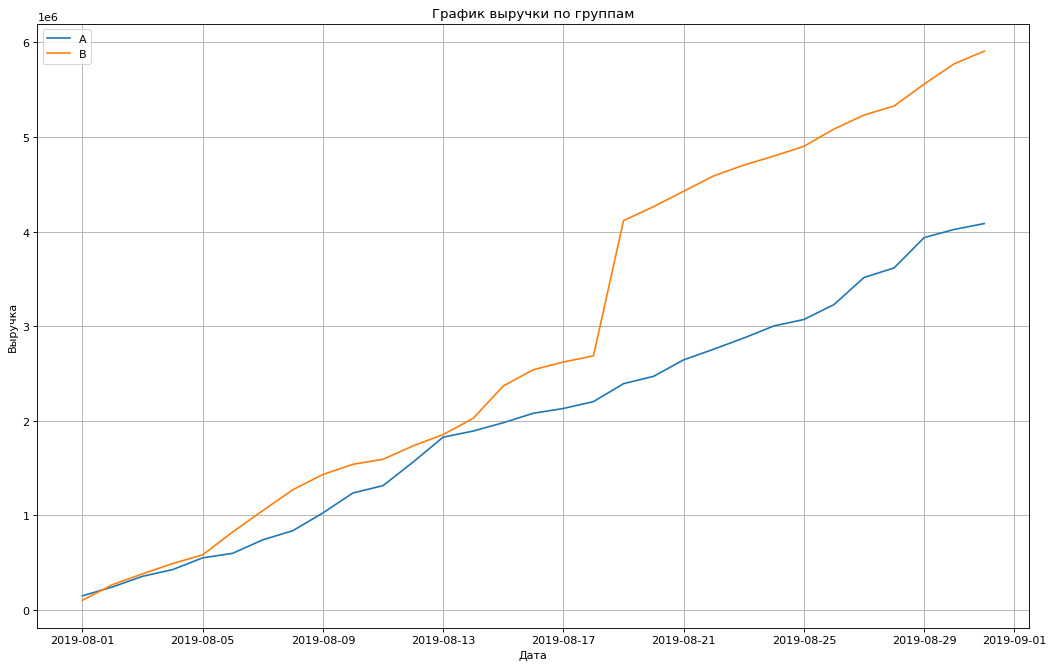

In [21]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]
plt.subplots(figsize=(16,10), dpi= 80)

# Строим график выручки группы А
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='A')
# Строим график выручки группы B
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='B')
plt.grid(True)
plt.title('График выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend();


Кумулятивная выручка группы B стабильно выше показателя группы А. Однако в интервале 17-21 августа был аномальный скачок у группы В - без него показатели могли сравняться.

#### Построим график кумулятивного среднего чека по группам

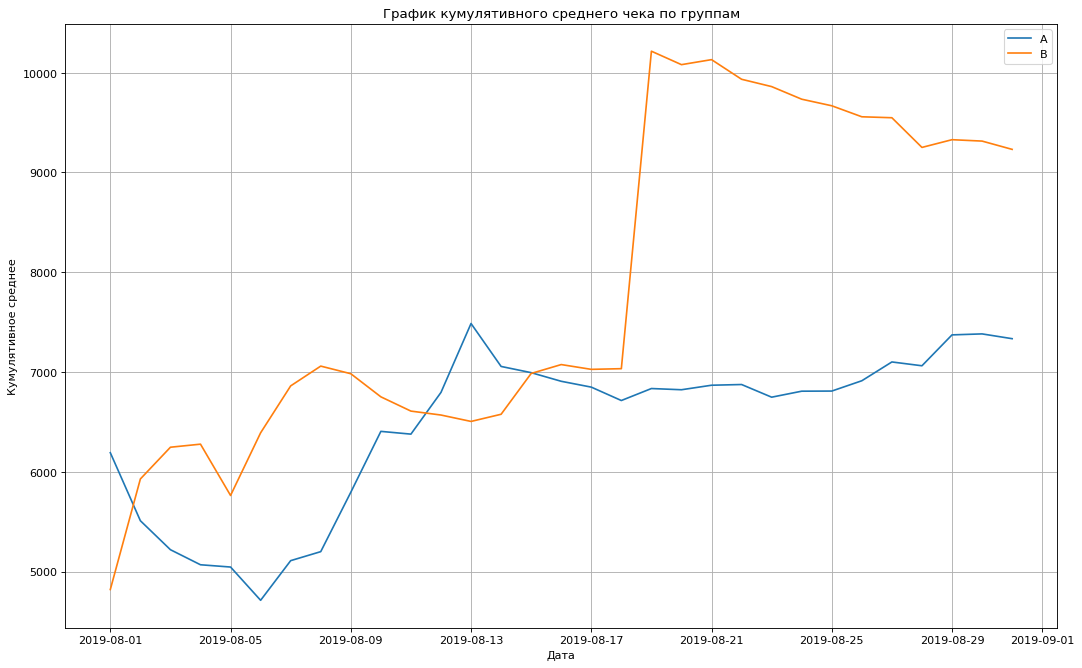

In [22]:
plt.subplots(figsize=(16,10), dpi= 80)
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue']/cumulative_revenue_A['orders'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue']/cumulative_revenue_B['orders'], label='B')
plt.grid(True)
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивное среднее')
plt.legend();

Кумулятивный средний чек группы В выше показателя группы А, но здесь также вмешался аномально высокий чек в интервале 17-21 августа.

Показатели группы А относительно стабильны во второй половине теста, показатели группы В стабильно падают.

#### Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

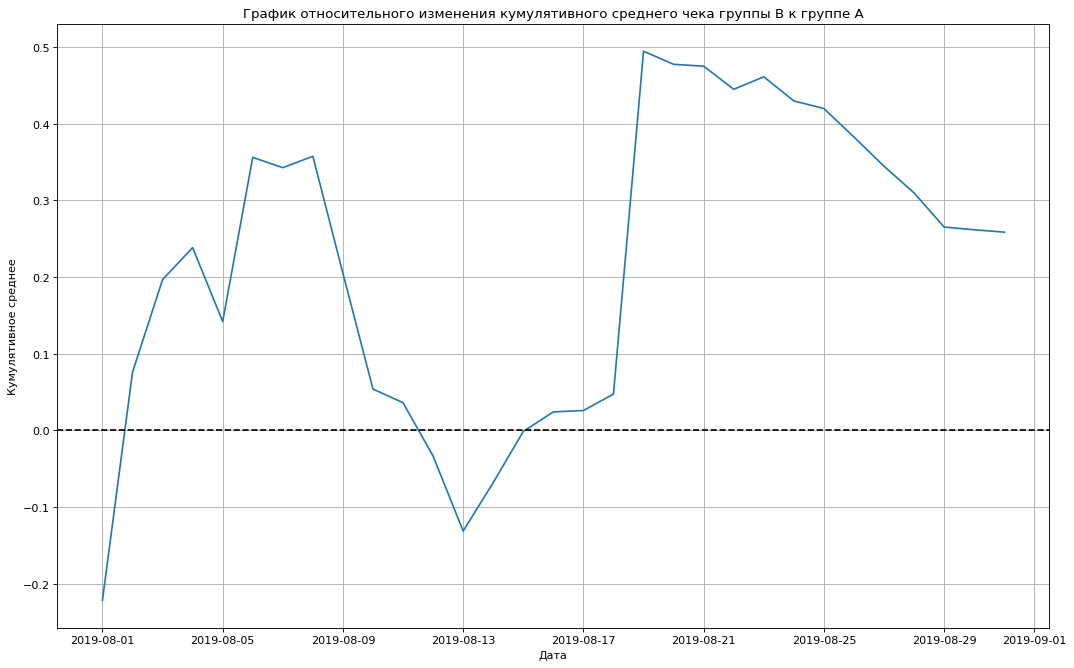

In [23]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_A.merge(cumulative_revenue_B, left_on='date',
right_on='date', how='left', suffixes=['A', 'B'])
# cтроим отношение средних чеков
plt.subplots(figsize=(16,10), dpi= 80)
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

plt.grid(True)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Кумулятивное среднее')
plt.axhline(y=0, color='black', linestyle='--');

Результаты теста значительно менялись между 9 и 18 августа - в эти даты и сделали аномальные заказы.

#### Построим график кумулятивного среднего количества заказов на посетителя по группам


In [24]:
cumulative_data['avg'] = cumulative_data['orders']/(cumulative_data['visitors'])


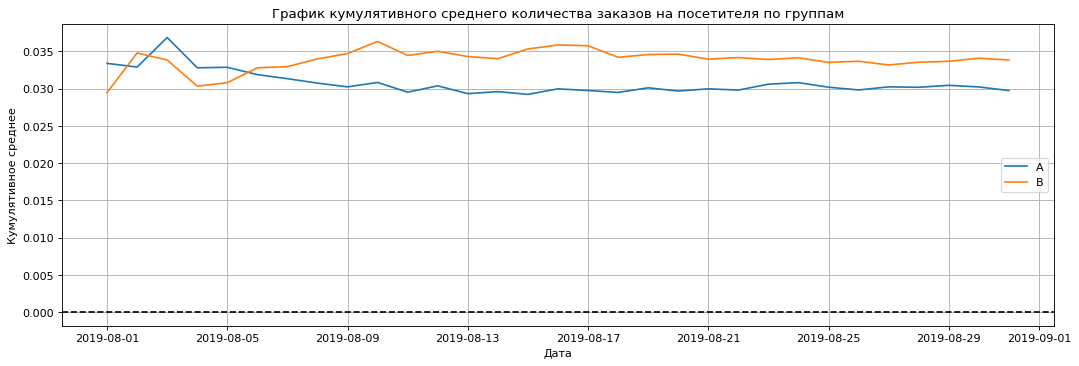

In [25]:
# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

plt.subplots(figsize=(16,5), dpi= 80)
plt.plot(cumulative_data_a['date'], cumulative_data_a['avg'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['avg'], label='B')
plt.legend()
plt.grid(True)
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивное среднее')
plt.axhline(y=0, color='black', linestyle='--');



Показатели среднего количества заказов на посетителя в обеих группах стабильные, у группы В незначительно выше.

#### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

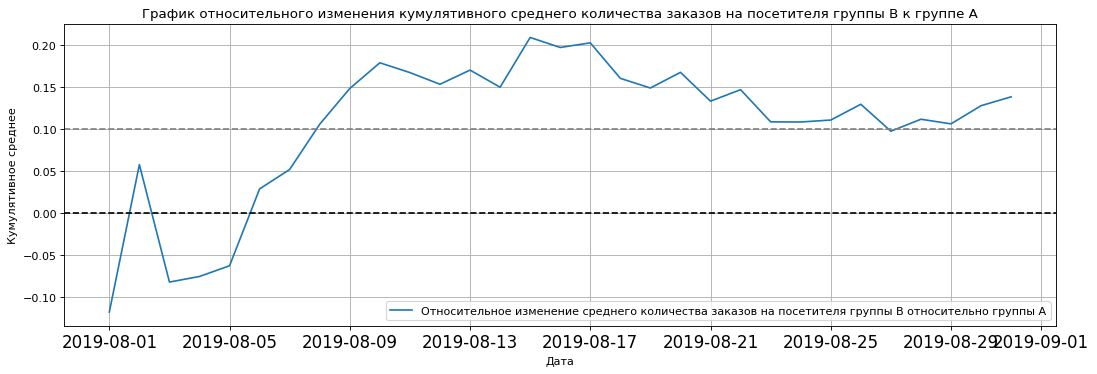

In [26]:
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.subplots(figsize=(16,5), dpi= 80)
plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1, label="Относительное изменение среднего количества заказов на посетителя группы B относительно группы A")

plt.legend()

plt.grid(True)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')

# размер шрифта по оси x
plt.tick_params(axis='x', which='major', labelsize=15)

plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Кумулятивное среднее');

По среднему количеству заказов на посетителя почти с самого начала теста группа В лидирует, в конце теста превосходит группу А примерно на 10%.

#### Построим точечный график количества заказов по пользователям

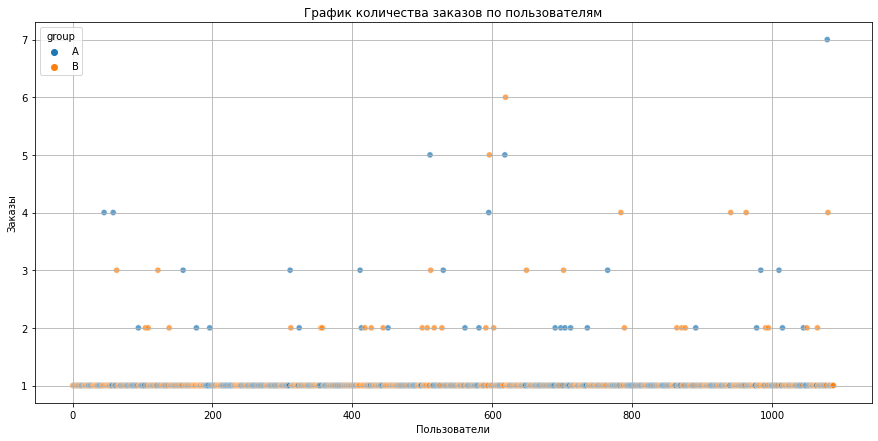

In [27]:
orders_by_users = orders.groupby(['visitor_id', 'group'], as_index=False).agg({'transaction_id': 'nunique'})
orders_by_users.columns = ['visitor_id','group','orders']
x_values = pd.Series(range(0,len(orders_by_users)))

plt.figure(figsize=(15, 7))
plt.grid(True)
ax = sns.scatterplot(x=x_values, y="orders", hue='group',hue_order=['A', 'B'],
                     data=orders_by_users, alpha=.7)
plt.title('График количества заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Заказы')
plt.show()

Много пользователей с 1-2 заказами. Однако принято отсеивать от 1% до 5% наблюдений с крайними значениями. 

#### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [28]:
print('Количество заказов для 95% и 99% пользователей = {}'
      .format(np.percentile(orders_by_users['orders'], [95, 99])))

Количество заказов для 95% и 99% пользователей = [2. 4.]


Не более 5% пользователей оформляли больше чем 2 заказов. И 1% пользователей заказывал более 4 раз. 

Аномальным будем считать количество заказов больше 4.

#### Построим точечный график стоимостей заказов

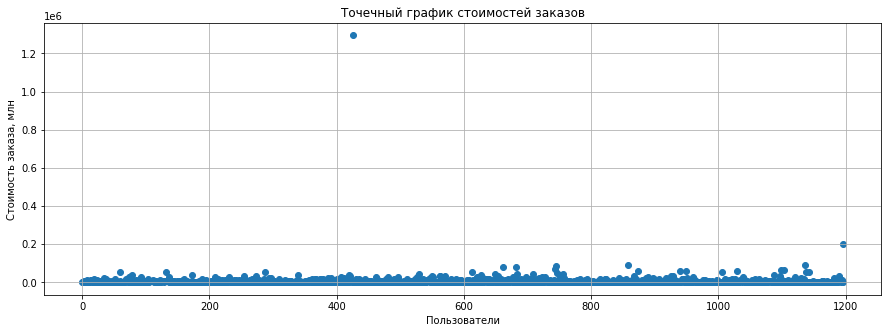

In [29]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(15, 5))
plt.grid(True)
plt.scatter(x_values, orders['revenue']);
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказа, млн');

По графику можно выбрать границу аномальных заказов до 100 тысяч рублей.Поскольку это большой промежуток, посчитаем перцентили.

#### Посчитаем 95-й и 99-й перцентили стоимости заказов

In [30]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Не более 5% пользователей оформляли заказы дороже 28 тысяч рублей. И 1% пользователей заказывал товары более, чем на 58,3 тысяч рублей.

Аномальным будем считать заказы дороже 58 234 рублей.

#### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Нулевая гипотеза: Cтатистически значимых различий в среднем количестве заказов на посетителя между группой B и группой А нет 

Альтернативная гипотеза: Cтатистически значимые различия в среднем количестве заказов на посетителя между группой B и группой А есть

In [31]:
orders_a = orders.query('group == "A"').reset_index(drop=True)
orders_b = orders.query('group == "B"').reset_index(drop=True)
orders_by_users_a = orders_by_users.query('group == "A"').reset_index(drop=True)
orders_by_users_b = orders_by_users.query('group == "B"').reset_index(drop=True)

sample_a = pd.concat([orders_by_users_a['orders'],
                     pd.Series(0, index=np.arange(cumulative_data_a['visitors'].sum() - len(orders_by_users_a['orders'])),
                               name='orders')],axis=0)

sample_b = pd.concat([orders_by_users_b['orders'],
                     pd.Series(0, index=np.arange(cumulative_data_b['visitors'].sum() - len(orders_by_users_b['orders'])),
                               name='orders')],axis=0)



print('p-значение: {:.3f}'.format(stats.mannwhitneyu(sample_a, sample_b)[1]))

print("Относительный прирост среднего количества заказов на посетителя группы B: {0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

p-значение: 0.015
Относительный прирост среднего количества заказов на посетителя группы B: 0.144


P-value меньше 0.05. Нулевую гипотезу отвергаем, по «сырым» данным, в среднем числе заказов на посетителя группа B выше группы А на 14,4%.


#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

Нулевая гипотеза: Cтатистически значимых различий в среднем чеке заказа между группой B и группой А нет 

Альтернативная гипотеза: Cтатистически значимые различия в среднем чеке заказа между группой B и группой А есть

In [32]:
print('p-значение: {:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("Относительный прирост в среднем чеке группы B: {0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-значение: 0.729
Относительный прирост в среднем чеке группы B: 0.259


P-value значительно выше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке по сырым данным есть различия, нет. Средний чек группы B выше среднего чека группы A на 25,9%.

#### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Нулевая гипотеза: Cтатистически значимых различий в среднем количестве заказов на посетителя между группой B и группой А нет 

Альтернативная гипотеза: Cтатистически значимые различия в среднем количестве заказов на посетителя между группой B и группой А есть

In [33]:
users_with_many_orders = orders_by_users[orders_by_users['orders'] > 4]['visitor_id']
users_with_expensive_orders = orders[orders['revenue'] > 58234]['visitor_id']
abnormal_users = (pd.concat([users_with_many_orders, users_with_expensive_orders], axis = 0)
                 .drop_duplicates()
                 .reset_index(drop=True))
sample_a_filtered = pd.concat(
    [orders_by_users_a[np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))]['orders'],
     pd.Series(0, index=np.arange(cumulative_data_a['visitors'].sum() - len(orders_by_users_a['orders'])),
               name='orders')],axis=0)

sample_b_filtered = pd.concat(
    [orders_by_users_b[np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))]['orders'],
     pd.Series(0, index=np.arange(cumulative_data_b['visitors'].sum() - len(orders_by_users_b['orders'])),
               name='orders')],axis=0)

alpha = 0.05
results = stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)
print('p-значение: {:.3f}'.format(results.pvalue))
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: "Cтатистически значимых различий в среднем количестве заказов на посетителя между группами нет".')
else:
    print('Не получилось отвергнуть нулевую гипотезу: "Cтатистически значимых различий в среднем количестве заказов на посетителя между группами нет".')

print("Относительный прирост среднего количества заказов на посетителя группы B: {0:.3f}"
      .format(sample_b_filtered.mean()/sample_a_filtered.mean() - 1))

p-значение: 0.013
Отвергаем нулевую гипотезу: "Cтатистически значимых различий в среднем количестве заказов на посетителя между группами нет".
Относительный прирост среднего количества заказов на посетителя группы B: 0.159


Результаты по среднему количеству заказов практически не изменились. 

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

Нулевая гипотеза: Cтатистически значимых различий в среднем чеке заказа между группой B и группой А нет 

Альтернативная гипотеза: Cтатистически значимые различия в среднем чеке заказа между группой B и группой А есть

In [34]:
results = stats.mannwhitneyu(orders_a[np.logical_not(orders_a['visitor_id'].isin(abnormal_users))]['revenue'],
                             orders_b[np.logical_not(orders_b['visitor_id'].isin(abnormal_users))]['revenue'])
print('p-значение: {:.3f}'.format(results.pvalue))
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: "Cтатистически значимых различий в среднем чеке между группами нет".')
else:
    print('Не получилось отвергнуть нулевую гипотезу: "Cтатистически значимых различий в среднем чеке между группами нет".')

print("Относительный прирост в среднем чеке группы B: {0:.3f}"
      .format(orders_b[np.logical_not(orders_b['visitor_id'].isin(abnormal_users))]['revenue'].mean()
              / orders_a[np.logical_not(orders_a['visitor_id'].isin(abnormal_users))]['revenue'].mean() - 1))

p-значение: 0.851
Не получилось отвергнуть нулевую гипотезу: "Cтатистически значимых различий в среднем чеке между группами нет".
Относительный прирост в среднем чеке группы B: -0.006


P-value увеличился, но разница между сегментами сократилась с 25% до 0.

#### Выводы по разделу 3

Есть статистически значимое различия по среднему количеству заказов между группами как по «сырым», так по данным после фильтрации аномалий;  

Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;

График различия среднего количества заказов между группами сообщает, что результаты группы B лучше группы A и достаточно стабильны.

По среднему количеству заказов на посетителя почти с самого начала теста группа В лидирует, в конце теста превосходит группу А примерно на 10%.
График различия среднего чека говорит о том, что результаты группы B еще не стабилизировались, нов ыше группы А в конце теста больше, чем на 20%.

**Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. При имеющихся данных сегмент B лучше сегмента A по показателю среднего количества заказов.**